In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import geopandas as gpd
from geopandas import GeoDataFrame

from geojson import Point
from geojson import MultiPoint
from geojson import Polygon

import folium

import os
import json

In [3]:
demanda = pd.read_csv("Input - Demanda/demanda.csv")

In [4]:
demanda.drop(columns =['id', 'mes', 'agente_nemo', 'agente_descripcion', 'tipo_agente', 'region', 'categoria_area', 'categoria_demanda', 'tarifa', 'anio'], inplace = True)
demanda.fillna(0, inplace=True)

## Demanda sum

In [5]:
demanda_sum = demanda

In [6]:
array = ['2016-01', '2016-06', '2017-01', '2017-06', '2018-01', '2018-06', '2019-01', '2019-06']
demanda_sum = demanda_sum.loc[demanda_sum['indice_tiempo'].isin(array)]

In [7]:
demanda_sum = demanda_sum.groupby(['provincia', 'categoria_tarifa', 'indice_tiempo'])['demanda_MWh'].aggregate(sum)
demanda_sum = demanda_sum.reset_index()

## Demanda sum - Catamarca

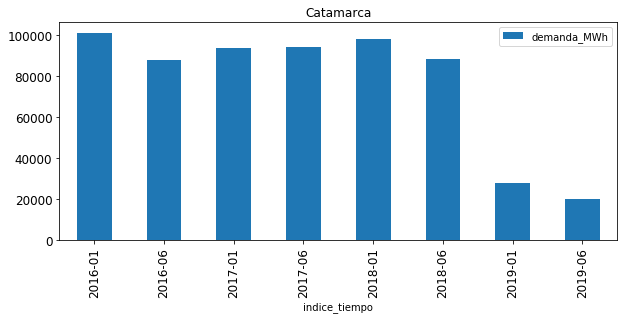

In [8]:
CATAMARCA = demanda_sum.loc[demanda_sum['provincia'] == 'CATAMARCA']
CATAMARCA = CATAMARCA.loc[CATAMARCA['categoria_tarifa'] == 'Industrial/Comercial Grande']
ax = CATAMARCA.plot(x='indice_tiempo', y='demanda_MWh', kind='bar', figsize=(10, 4), fontsize=12, title='Catamarca')

## Demanda sum - Chubut

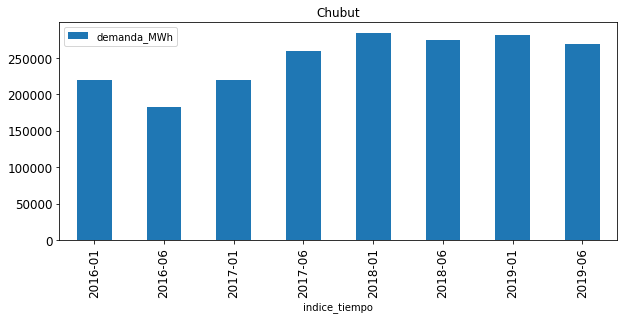

In [9]:
CHUBUT = demanda_sum.loc[demanda_sum['provincia'] == 'CHUBUT']
CHUBUT = CHUBUT.loc[CHUBUT['categoria_tarifa'] == 'Industrial/Comercial Grande']
ax = CHUBUT.plot(x='indice_tiempo', y='demanda_MWh', kind='bar', figsize=(10, 4), fontsize=12, title='Chubut')

## Demanda sum - Provincias

In [10]:
provincias = demanda_sum.loc[demanda_sum['categoria_tarifa'] == 'Industrial/Comercial Grande']
provincias.drop(columns =['indice_tiempo', 'categoria_tarifa'], inplace = True)

C:\Users\martin\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [11]:
describe = pd.DataFrame(columns = ['provincia']) 
#provincias = provincias.reset_index()

In [12]:
promedio = provincias.groupby('provincia').mean()
promedio = promedio.reset_index()
std = provincias.groupby('provincia').std()
std = std.reset_index()

In [13]:
describe['provincia'] = promedio['provincia']
describe['promedio'] = promedio['demanda_MWh']
describe['std'] = std['demanda_MWh']
describe = describe.sort_values(by=['promedio']).reset_index() 

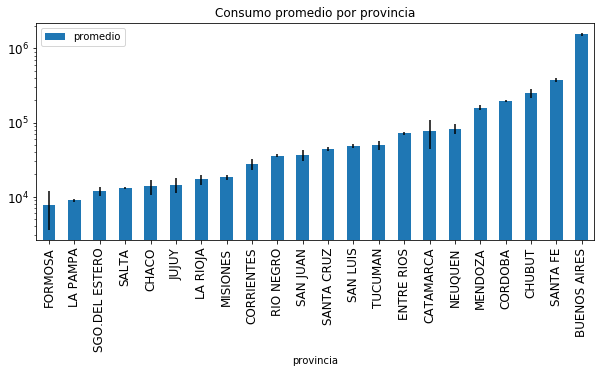

In [14]:
ax = describe.plot(x='provincia', y='promedio', kind='bar', figsize=(10, 4), fontsize=12, title='Consumo promedio por provincia', yerr='std', logy=True)

In [15]:
demanda_sum['indice_tiempo'] = 'Consumo ' + demanda_sum['indice_tiempo']

In [16]:
demanda_sum = pd.pivot_table(demanda_sum, values='demanda_MWh', columns='indice_tiempo', index =['provincia', 'categoria_tarifa'])
demanda_sum = demanda_sum.reset_index()

## Demanda count

In [17]:
demanda_count = demanda

In [18]:
array = ['2016-01', '2016-06', '2017-01', '2017-06', '2018-01', '2018-06', '2019-01', '2019-06']
demanda_count = demanda_count.loc[demanda_count['indice_tiempo'].isin(array)]

In [19]:
demanda_count['indice_tiempo'] = 'Cantidad ' + demanda_count['indice_tiempo']

C:\Users\martin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
demanda_count.columns

Index(['provincia', 'categoria_tarifa', 'demanda_MWh', 'indice_tiempo'], dtype='object')

In [21]:
demanda_count['categoria'] = demanda_count['categoria_tarifa']

C:\Users\martin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
demanda_count = demanda_count.groupby(['provincia', 'categoria_tarifa', 'indice_tiempo'])['categoria'].count().reset_index()

In [23]:
demanda_count = pd.pivot_table(demanda_count, values='categoria', columns='indice_tiempo', index =['provincia', 'categoria_tarifa'])
demanda_count = demanda_count.reset_index()

# Analisis 0

In [24]:
analisis0 = pd.merge(demanda_count, demanda_sum, left_index=True, right_index=True)
analisis0.drop(columns =['provincia_y', 'categoria_tarifa_y'], inplace = True)
analisis0.rename(columns = {'provincia_x':'provincia', 'categoria_tarifa_x':'categoria_tarifa'}, inplace = True) 
analisis0 = analisis0.loc[analisis0['categoria_tarifa'] != 'Mercado a Término']

In [25]:
analisis0['Delta_consumo_enero_16-19'] = (analisis0['Consumo 2019-06'] - analisis0['Consumo 2016-06']) / analisis0['Consumo 2016-06']

## Analisis 1 por categoria_tarifa

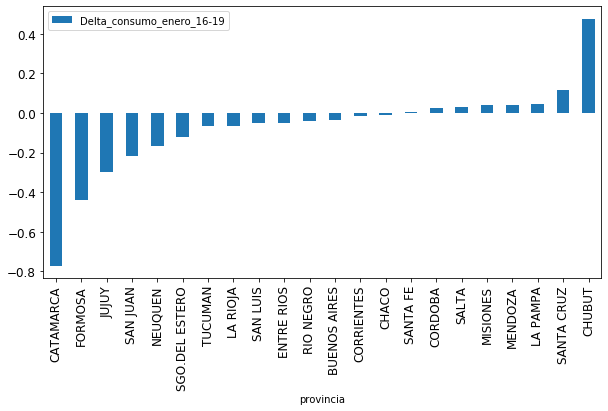

In [26]:
analisis1 = analisis0.loc[analisis0['categoria_tarifa'] == 'Industrial/Comercial Grande']
analisis1 = analisis1.sort_values(by=['Delta_consumo_enero_16-19']).reset_index() 
ax = analisis1.plot(x='provincia', y='Delta_consumo_enero_16-19', kind='bar', figsize=(10, 5), fontsize=12)

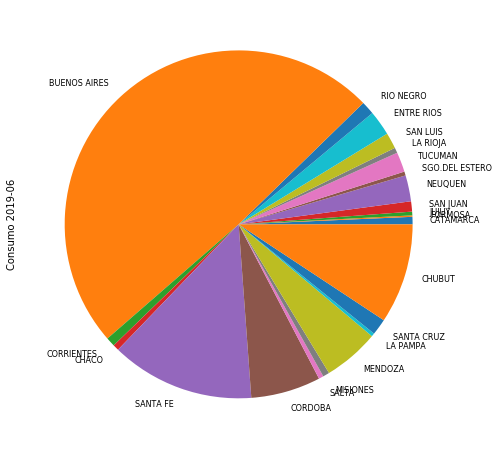

In [27]:
ax = analisis1.plot(x='provincia', y='Consumo 2019-06', kind='pie', labels = analisis1['provincia'], figsize=( 8, 8), fontsize= 8, legend=False)

In [28]:
analisis1.to_csv('Output - Demanda//analisis1.csv')  #Utilice este csv para Power BI

In [29]:
analisis1.head(30)

indice_tiempo,index,provincia,categoria_tarifa,Cantidad 2016-01,Cantidad 2016-06,Cantidad 2017-01,Cantidad 2017-06,Cantidad 2018-01,Cantidad 2018-06,Cantidad 2019-01,Cantidad 2019-06,Consumo 2016-01,Consumo 2016-06,Consumo 2017-01,Consumo 2017-06,Consumo 2018-01,Consumo 2018-06,Consumo 2019-01,Consumo 2019-06,Delta_consumo_enero_16-19
0,5,CATAMARCA,Industrial/Comercial Grande,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,101246.398,87816.281,93990.404,94441.500,98276.994,88662.659,27675.810,20018.617,-0.772040
1,29,FORMOSA,Industrial/Comercial Grande,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,4791.898,6843.092,8919.368,6206.294,7853.294,6437.469,17701.093,3841.173,-0.438679
2,33,JUJUY,Industrial/Comercial Grande,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,16154.970,14248.336,15346.184,16971.034,15877.509,18456.322,9202.357,9984.111,-0.299279
3,65,SAN JUAN,Industrial/Comercial Grande,12.0,12.0,12.0,12.0,12.0,11.0,11.0,11.0,48509.846,35214.621,36135.670,37490.485,40201.425,31491.366,33163.545,27561.794,-0.217320
4,53,NEUQUEN,Industrial/Comercial Grande,18.0,18.0,18.0,18.0,18.0,18.0,17.0,17.0,91739.189,83933.393,107430.417,78468.725,84994.507,71648.967,75240.260,69933.649,-0.166796
5,81,SGO.DEL ESTERO,Industrial/Comercial Grande,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,12703.094,12155.278,12714.620,13966.878,10021.008,13015.879,9553.716,10698.881,-0.119816
6,85,TUCUMAN,Industrial/Comercial Grande,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,47278.853,57303.185,45991.456,56372.839,40119.762,56895.263,40074.058,53518.354,-0.066049
7,41,LA RIOJA,Industrial/Comercial Grande,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,22330.285,15147.105,16710.402,17866.584,19402.911,16962.755,13967.670,14179.930,-0.063852
8,69,SAN LUIS,Industrial/Comercial Grande,9.0,9.0,9.0,9.0,9.0,10.0,11.0,11.0,51359.705,45306.563,49120.877,46715.884,50300.445,47352.617,50036.685,42911.478,-0.052864
9,25,ENTRE RIOS,Industrial/Comercial Grande,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,75796.576,71003.470,72079.180,69457.764,75638.370,68041.369,70415.121,67268.670,-0.052600


## Mapa!

In [30]:
import shapely.wkt
from shapely.wkt import loads

In [32]:
provincia = pd.read_csv("Input - Demanda//provincia.csv")
provincia.drop(columns =['Unnamed: 0'], inplace = True)

### Layer con las provincias

In [33]:
m = folium.Map([-34.606359, -58.443863], zoom_start=12, tiles="OpenStreetMap")
def from_wkt(df, wkt_column):
    #import shapely.wkt
    df["coordinates"] = df['WKT'].apply(shapely.wkt.loads)
    gdf = gpd.GeoDataFrame(df, geometry='coordinates')
    return gdf

In [34]:
provincia = from_wkt(provincia, "WKT")
perimetro = provincia.to_json()
folium.GeoJson(perimetro).add_to(m)

### Layer con el consumo de Julio del 2019

In [35]:
bins = list(analisis1['Consumo 2019-06'].quantile([0, 0.25, 0.5, 0.75, 1]))
bins = bins

folium.Choropleth(
    geo_data=perimetro,
    data=analisis1,
    columns=['provincia', 'Consumo 2019-06'],
    key_on='feature.properties.nam',
    fill_color='YlOrRd',  #YlGn
    name='Consumo 2019-06',
    bins = bins,
    fill_opacity=0.8,
    line_opacity=0.5,
    legend_name='Consumo 2019-06',
    nan_fill_color= 'black',
    show=False,
).add_to(m)

### Layer con la variacion de consumo entre el 2016 y el 2019

In [36]:
analisis1['Delta_consumo_enero_16-19'] = analisis1['Delta_consumo_enero_16-19']*(-1)

In [37]:
folium.Choropleth(
    geo_data=perimetro,
    data=analisis1,
    columns=['provincia', 'Delta_consumo_enero_16-19'],
    key_on='feature.properties.nam',
    fill_color='PuBuGn',  #YlGn
    name='Delta_consumo_enero_16-19',
    fill_opacity=0.8,
    line_opacity=0.5,
    legend_name='Delta_consumo_enero_16-19',
    nan_fill_color= 'black',
    show=False,
).add_to(m)

In [38]:
folium.LayerControl().add_to(m)
m.save(os.path.join('Output - Demanda//Mapa.html'))